In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

## Table of Contents
* [Functions used for fisrt part assignment](#chapter1)
* [Functions used for second part assignment](#chapter2)
* [Functions used for third part assignment](#chapter3)
    * [Main](#main)

## Functions used for segmentation part 1 <a class="anchor" id="chapter1"></a>

In [2]:
def image_segmantation(frame, file_name):
    img_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    # preprocessing:
    # modify the brightness of the image 
    # we need to solve the problem of background color in the area close to the bottom of the yellow glass
    # othewrise we had problem in image segmentation
    gammaImg = gammaCorrection(img_rgb, 2.2)
    # convert to YUV model color
    img_yuv = cv.cvtColor(gammaImg, cv.COLOR_RGB2YUV)
    # Normalize UV channels between [-0.5 ... 0.5]
    UV = img_yuv[:,:,1:3] / 255.0 - 0.5 
    # we choosed 0.4 -0.4 based on the UV plane (blue)
    mask = chroma_distance( UV, 0.4, -0.4 )
    # correspond to left part of the image that correspond always to foreground 
    mask[:,1220:] = 0.51
    # right part of the image (background)
    mask[:,:250] = 0.4
    # color pixel:
    # foreground white
    mask[mask > 0.5 ] = 255
    # background black
    mask[mask <= 0.5 ] = 0
    # parrot
    if file_name == "obj01":
        return morphological_operation_parrot(mask)
    else:
        if  file_name == "obj03":
             # cracker
            return morphological_operation_cracker(mask)
        else:
            return morphological_operation(mask)

In [3]:
# used to correct the brightness of an image 
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma
    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
    return cv.LUT(src, table)

In [4]:
# calculate euclidian distance between color
def chroma_distance( UV, u, v ):
    return np.sqrt( (UV[:,:,0]-u)**2 + (UV[:,:,1]-v)**2 )

In [5]:
# to clean the image from noise 
def morphological_operation_parrot(img):
    # use different size of structural element
    # use to close the gap for the foreground object
    se_ = cv.getStructuringElement(cv.MORPH_ELLIPSE,(57,57))
    # clean the little noise use for erosion
    se = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
    # first we apply erosin to clean the noise 
    erode_ = cv.erode(img,se, iterations = 1)
    # we apply dilate to close the gap 
    dilate = cv.dilate(erode_,se_,iterations = 1)
    return dilate 

In [6]:
def morphological_operation_cracker(img):
    # use different size of structural element
    # use to close the gap for the foreground object
    se_ = cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10))
    # clean the little noise use for erosion
    se = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
    # first we apply erosin to clean the noise 
    erode_ = cv.erode(img,se, iterations = 1)
    # we apply dilate to close the gap 
    dilate = cv.dilate(erode_,se_,iterations = 3)
    # clean again the noise created with dilatation
    final = cv.erode(dilate,se_, iterations = 1)
    return final 

In [7]:
def morphological_operation(img):
    # use to close the gap for the foreground object
    se = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
    se_ = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
    # first we apply erosin to clean the noise 
    erode = cv.erode(img,se, iterations = 1)
    dilate = cv.dilate(erode,se_, iterations = 1)
    return dilate

## Functions used for second  part  <a class="anchor" id="chapter2"></a>

In [8]:
# given 5 vertex of the polygon find the one that is concave 
# the sum of internal angle of a polygon is (n - 2)* 180 
def find_concave_angle(contours):
    # read clockwise order
    # need clock wise otherwise doesnt work 
    clockwise = contours[::-1]
   
    # take first and last 
    v1 = clockwise[-1] - clockwise[0]
    v2 = clockwise[1] - clockwise[0]
    # if cross product is negative means that angle is between 180 and 360 so it is the concave one 
    # |a| x |b| = |a||b| sin(teta) n
    # magnitude is always positive so only the sin(teta) give the sign 
    # so if is negative we know that the angle is betwenn 180 and 360 
    # NB DONT KNOW WHY IT READ ALWAYS THE INTERNAL ANGLE ?????
    # np.cross(a,b) with 2D vector assume z equal to 0
    if np.cross(v1, v2) < 0:
            return clockwise[0], 0
    for i in range(1 ,len(contours) - 1):
        v1 = clockwise[i-1] - clockwise[i]
        v2 = clockwise[i+1] - clockwise[i]
        if np.cross(v1, v2) < 0:
            return clockwise[i], i
    # case not find any concave vertex
    return None, None

In [9]:
# read the binary code 
def read_binary_code(contour, concave_index, otsu_img):
    # read clockwise
    clockwise = contour[::-1]
    # two vertex we are interested in
    # are always the second and the third one respect the concave vertex
    v1 = clockwise[((concave_index + 2) % 5)]
    v2 = clockwise[((concave_index + 3) % 5)]
    # find the point in the middle of the segment v1, v2
    v6 = v1 * (0.5) + v2 * (0.5)
    number = 0
    # calculate position for the marker 
    for i in range(1,6):
        # black mean 1
        # position where to look for the dot marker
        # 0.166 = 1 / 6 = 1 /( d + 1 ) = lenght of each uniform piece along the line
        pos = v6 * (0.166 * i ) + clockwise[concave_index]  * (1 - (0.166 * i))
        # if black dot
        # recall image is seen as matrix so x and y axis are opposite respect the cartesian 
        if otsu_img[int(pos[0][1]),int(pos[0][0])] == 0:
            number += np.power(2,i - 1)
    return number

In [10]:
def feautures_detection(frame_gray):
    
    # apply thresholding to convert the grayscale image to a binary image
    ret,thresh = cv.threshold(frame_gray,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    # find the contours
    contours,hierarchy = cv.findContours(thresh, cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    
    # list containing all corner features
    corner_feautures = []
    
    # concave vertex 
    concave_list = []
   
    # number list 
    number_list = []
  

    for c in contours:

        # define the precision 0.11 0.13 0.14 0.17 a bit better
        epsilon = 0.017 * cv.arcLength(c,True)

        # approximate the contour
        approx = cv.approxPolyDP(c,epsilon,True)

        # computing area 
        area = int(cv.contourArea(approx))


        # draw the aproximation
        #  is a polygon with 5 vertex                               to be sure to take only polygon in the plate
        if len(approx) in range(5,7) and area in range(1000,8649) and approx[0][0][0] in range(1100, 1600):

            # i have to define better the countorn
            if len(approx) == 6:

                approx = cv.approxPolyDP(approx,8.641,True)
                
                # refine the corners to subpixel accuracy
                approx = cv.cornerSubPix(thresh,np.float32(approx), (5,5),(-1,-1),(cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001))
                
                concave_point, index_concave_vertex = find_concave_angle(approx)

            # case 5 vertex 
            else:
                
                # refine the corners to subpixel accuracy
                approx = cv.cornerSubPix(thresh,np.float32(approx), (5,5),(-1,-1),(cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001))
                # find the concave point
                concave_point, index_concave_vertex = find_concave_angle(approx)
                

            # check concave vertex found it
            if index_concave_vertex != None and len(approx) == 5:
                
                # polygon counturn with concave vertex
                corner_feautures.append(approx)
                
                # decode binary encoding
                number = read_binary_code(np.int32(approx), index_concave_vertex, thresh)
                
                # decoded number
                number_list.append(number)
                
                # concave vertex 
                clockwise = approx[::-1]
                concave_list.append(clockwise[index_concave_vertex])
               
   
    # vertex index
    p0 = np.array(corner_feautures, dtype = np.float32)
    # concave vertices
    concave_vertices = np.array(concave_list, dtype = np.float32 )
    
    #counturn vertecises, concave vertices, number decoded
    return p0, concave_vertices, number_list

In [11]:
# filter polygon point 
# we need to dont propagate point that are detected with optical flow but then are they sould be behind the object
def filter_polygon(p, flag):
    # reshape
    p = np.array(np.reshape(p, (-1, 5, 2)))
    # save index to delete
    to_delete = []
    # case exit from glass
    if flag:
        for enum, cordinate  in enumerate(zip(p[:,:,0], p[:,:,1])):
             # check the range for x 
            x = np.where((cordinate[0]< 1207. ), True, False)
            # if any of thr polygon vertex are in the area we have to delete all of them
            if x.any():
                to_delete.append(enum)
         # delete poygon detected
        x = np.delete(p, to_delete, 0)  
        # reshape 
        x =  np.reshape(x,(-1,2))
        return x
    
    # case enter in the glass
    else:
        #                                   x cordinate y cordinate 
        for enum, cordinate  in enumerate(zip(p[:,:,0], p[:,:,1])):
            # check the range for x 
            x = np.where((cordinate[0]< 1250. ), True, False)
            # check the range for y 
            y = np.where(( cordinate[1] > 550. ) & ( cordinate[1] < 750. ), True, False)

            # if at least a true i have to delete the polygon 
            if x.any() & y.any():
                # print(f'enum {enum}')
                to_delete.append(enum)

        # delete poygon detected
        x = np.delete(p, to_delete, 0)  
        # reshape 
        x =  np.reshape(x,(-1,2))
        return x

In [12]:
# filter concave vertex that are detected with optical flow but then are behind the object 
# so we have to remove them 
def filter_concave_vertex(concave_vertex, number, flag):
    # case exit the glass
    if flag:
        # third check x 
        third_range = np.argwhere(concave_vertex[:,0] < 1235. )
         #delete value that respect the condtion 
        filtered_concave_vertex = np.delete(concave_vertex,third_range,0)
        # reshape
        concave_vertex =  np.reshape(filtered_concave_vertex,(-1,2))
    
        # filter number decoded
        number = np.delete(number, third_range,0)
        return concave_vertex, number
    # case enter the glass
    else:
        # first check y
        first_range = np.argwhere(concave_vertex[:,1] >  550.) 
        # second check y
        second_range = np.argwhere(concave_vertex[:,1] < 777.) 
        # third check x 
        third_range = np.argwhere(concave_vertex[:,0] < 1250. )

        # verify multiple condition
        x = np.intersect1d(first_range, second_range)
        z = np.intersect1d(x, third_range)

        #delete value that respect the condtion 
        filtered_concave_vertex = np.delete(concave_vertex,z,0)
        # reshape
        concave_vertex =  np.reshape(filtered_concave_vertex,(-1,2))

        # filter number decoded
        number = np.delete(number, z,0)
        return concave_vertex, number

## Functions used for third part  <a class="anchor" id="chapter3"></a>

In [13]:
camera_matrix = np.load('Data/camera_matrix.npy')
dist_coef = np.load('Data/dist_coef.npy')

In [14]:
def main(file_name, verbose = False):
    path = "Data/" + file_name + ".mp4"
   # lucas kanade params
    lk_params = dict(winSize = (10,10),
                    maxLevel = 2,
                    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

    # read first frame
    vid = cv.VideoCapture(path)
    # Take first frame and find corners in it
    ret, old_frame = vid.read()
    # lukas kanade works with grayscale images
    # convert the image to grayscale
    old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

    # find good features 
    p0, concave_vertex, number = feautures_detection(old_gray)
    p0 = np.reshape(p0,(-1,2))
    concave_vertex_0 = np.reshape(concave_vertex,(-1,2))
    # frame count 
    frame_count = 0 
    
    
    # 3D point marker reference of real word
    object_point_original = determine_object_point_marker()
    # cube creation, create smaller cube, find center of each smaller cube
    # CUBE POINT real word 
    cube_3d_point = object_point_cube(130)
    # SPLIT CUBE into smaller ones
    cubes = split_cube(cube_3d_point, 130, 11)
    # find center of each cube
    center_cubes_3d = compute_center_cubes(cubes)
  
    
  
    while(vid.isOpened()):
        # read frame by frame
        ret, frame = vid.read()

        if not ret:
            print('No frames grabbed!')
            break

        # counting frame for refreh
        frame_count += 1
        # new frame 
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        # calculate optical flow              old frame,  new frame,  points, mask, param for lucas kanade
        p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, gray,p0 , None, **lk_params )

        # change size 
        p1 = np.reshape(p1,(-1,2))
        # filter vertex polygon enter the glass
        p1 = filter_polygon(p1, False)
        # concave vertex 
        # calculate optical flow              old frame,  new frame,  points, mask, param for lucas kanade
        concave_vertex_1, st, err = cv.calcOpticalFlowPyrLK(old_gray, gray,concave_vertex_0 , None, **lk_params )
        # change size 
        concave_vertex_1 = np.reshape(concave_vertex_1,(-1,2))
        # filter concave vertex that has been calculate with optical flow enteing the glass
        concave_vertex_1, number = filter_concave_vertex(concave_vertex_1, number, False)
        
        
        #----------THIRD ASSIGMENT PART------
        
        # take only the one we are interasting
        # CORRESPONDIG 3D POINT 
        object_point = object_point_original[number[::]]
        # calculate r_t matrix
        r_t = calcualte_rt(object_point, concave_vertex_1, camera_matrix, dist_coef)
        # transform 3d point real word into camera cordinate 
        # cube_3d_point.shape (8,3)
        cube_2d_point = transform3D22D(cube_3d_point, r_t, camera_matrix)
        # find foreground background
        segmented_img = image_segmantation(frame, file_name)
        # transform cordinate of the center of the cubes into camera cordinate 
        center_cube_2d_point = transform3D22D(center_cubes_3d, r_t, camera_matrix)
        # convert to int to display with cv.imshow
        center_cube_2d_point = np.array(center_cube_2d_point, dtype = np.int32)
        
        if verbose:
            # draw cube, central point of cubes, number decoded, polygon vertex, concave vertex
            frame = draw_frame(p1, concave_vertex_1, number,cube_2d_point, center_cube_2d_point, r_t, frame)
        
        else:
            # eliminate the point that are background 
            # element greater then 0 are foreground 
            mask = segmented_img[center_cube_2d_point[:,1],center_cube_2d_point[:,0]] > 0
            # get index
            index = np.argwhere(mask)
            # get the 3d point that i am interasting about
            center_cubes_3d = center_cubes_3d[index[:]]
            # squenze dimension that has 1
            center_cubes_3d = np.squeeze(center_cubes_3d)
            # eliminate cube that are background
            cubes = cubes[index[:]]
            # squeeze
            cubes = np.squeeze(cubes)
        
       
        cv.namedWindow("win1", cv.WINDOW_NORMAL )
        # show frame
        cv.imshow('win1', frame)
        
        # update frame
        old_gray = gray.copy()

        # every 20 frame 
        if frame_count % 20 == 0:
            # counturn vertecises, concave vertices, number decoded
            p0, concave_vertex_0, number = feautures_detection(old_gray)
            p0 = np.reshape(p0,(-1,2))
            # eliminate of polygon that are not respected the constraint we have
            p0 = filter_polygon(p0, True)
            
            concave_vertex_0 = np.reshape(concave_vertex_0,(-1,2))
             # filter concave vertex that has been calculate with optical flow
            concave_vertex_0, number = filter_concave_vertex(concave_vertex_0, number, True)
            
        else:
            # update old points
            # polygon points
            p0 = p1.copy()
            # concave vertex point
            concave_vertex_0 = concave_vertex_1.copy()

        if cv.waitKey(500) & 0xFF == ord('q'):
            break

    # After the loop release the vid object
    vid.release()
    # Destroy all the windows
    cv.destroyAllWindows()
    
    if not verbose:
        # write ply file with remaining cubes
        write_ply(cubes, file_name)
    return cubes.shape
    


In [15]:
def determine_object_point_marker():
    # 3D points 
    object_point_list = []
    # we have 24 mark
    for i in range(0,24):
        #    radius     every 15 degree we found concave vertex
        x = (70*   (np.cos(np.radians(15 * i ) )) )
        y = (70*  - (np.sin(np.radians(15 * i ))) )
        z = 0.
        object_point_list.append(np.array([x,y,z]))  
    object_point_original = np.array(object_point_list, dtype = np.float32)
    return object_point_original

In [16]:
# it calcualte the 3d real world cordinate of the cube
def object_point_cube(cube_side_length):
    # 3d real world cordinate for cube
    cube_object_point = []
    # two level of cube base and top
    for j in range(2):
        # 4 vertices of level i 
        for i in range(0,4):
            # lenght/np.sqrt(2) needed to fix the right lenght of ray 
            # i want two vertices be at equal distance
            # np.radians(90 * i ) each 90 degree a vertex of the cube
            #      ray                    right angle
            # + 45 to have the cube placed horrizontaly 
            x = (cube_side_length/np.sqrt(2)* (np.cos(np.radians(90 * i + 45 ) )) )
            y = (cube_side_length/np.sqrt(2)*   - (np.sin(np.radians(90 * i + 45 ))) )
            # right height for the base of the cube 
            z =  80 + cube_side_length * j
            cube_object_point.append(np.array([x,y,z]))  
    cube_object_point = np.array(cube_object_point, dtype = np.float32)
    # real world 3d cordinate cube
    return cube_object_point

In [17]:
def split_cube(cube_vertex, cube_side, split):
    # cube side of each little cube
    length = cube_side / (split - 1)
    # all vertex that create all the cubes
    vertices = []
    # create all the vertex of the cubes
    # over y axes
    for y_split in range(split):
         # start                         x                                  y             z
        origin_split_y = np.array([[cube_vertex[0,0], cube_vertex[0,1] + length * y_split, cube_vertex[0,2]]])

        # over z axes
        for z_split in range(split):
             # start                         x                                 y             z
            origin_split_x = np.array([[origin_split_y[0,0], origin_split_y[0,1], origin_split_y[0,2] + length * z_split]])
            # end opposite point respect the origin split
            end_split_x = np.array([ [origin_split_x[0,0] - cube_side, origin_split_x[0,1], origin_split_x[0,2]] ])
            # create the split
            # np array with number of point equal to split 
            vertices.append(np.linspace(origin_split_x, end_split_x, split))
            
    vertices = np.array(vertices)
    vertices = vertices.squeeze()
    # now we have to aggregate the vertex in correct manner to form each little cube vertex
    
    # y green 
    #            number of faces, faces split, linspace points, cordinate of each point
    vertices = vertices.reshape((split, split, -1, 3))
    cubes = []
    # each face
    for i in range(vertices.shape[0] - 1):
        # iterating over  split
        for j in range(vertices.shape[1] - 1):
            # iterating over linspace points
            for z in range(vertices.shape[2] -1):
                cube = []

                # point a
                cube.append(vertices[i][j][z])
                # point b
                cube.append(vertices[i][j][z + 1])
                # point c
                cube.append(vertices[i ][j+1][z])
                # point d
                cube.append(vertices[i][j+1][z+1])

                 # point e
                cube.append(vertices[i+1][j][z])
                # point f
                cube.append(vertices[i+1][j][z + 1])
                # point g
                cube.append(vertices[i+1 ][j+1][z])
                # point h
                cube.append(vertices[i+1][j+1][z+1])

                cubes.append(cube)   
    cubes = np.array(cubes)
    return cubes

In [18]:
# given cubes vertices it compute the center of each cube 
def compute_center_cubes(cubes):
    all_center = []
    for cube in cubes:
        #                          x                    y                    z
        center = np.array([np.sum(cube[:,0]), np.sum(cube[:,1]), np.sum(cube[:,2])])
        # divide by number of vertex to find center
        all_center.append(center/8)
    
    all_center = np.array(all_center)
    return all_center

In [19]:
# return rotation translation matrix
def calcualte_rt(object_point, image_point, camera_matrix, dist_coef):
     # solvePnp to find rotation and translation matrix
    ret, rvecs, tvecs = cv.solvePnP(object_point, image_point, camera_matrix, dist_coef, flags = cv.SOLVEPNP_IPPE)
    # transform rotation vector in rotation matrix
    dst, jacobian =	cv.Rodrigues(rvecs)	
    # create roation transition matrix
    # [RT] MATRIX
    r_t = np.concatenate((dst,tvecs),1)
    # r_t is a rotation and the translation vectors 
    # that transform a 3D point expressed in the object coordinate frame to the camera coordinate frame
    return r_t

In [20]:
# trasform 3d points int 2d points
def transform3D22D(point3d, r_t, camera_matrix):
    point_2d_list = []
    # padding to obdain 3d homogeneus cordinate
    for i in point3d:
        pad = np.pad(i, (0, 1), 'constant', constant_values=(1))
        
        # use rotation and transition matrix with camera intrinsic parameter
        # to convert 3d homogenus cordinate real word to camera cordinate
        camera_point = camera_matrix.dot(r_t).dot(pad)
        # divide by w cordinate to get 2d point
        camera_3d_point = camera_point[:] / camera_point[2]
        # take only x and y cordinate
        point2d = camera_3d_point[0:2]
        point_2d_list.append(point2d)
    point_2d_list = np.array(point_2d_list)
    return point_2d_list

In [21]:
def write_ply(cubes, filename):
    # pattern to draw correctly the face of each cube
    vertex_order = np.array([
        [2,3,1,0],
        [7,6,4,5],
        [7,3,2,6],
        [4,0,1,5],
        [4,6,2,0],
        [1,3,7,5]
    ])
    
    # write the vertex 
    f = open('Data/'+ filename + '.ply', "a")
    # write vertex
    for i in cubes:
        # each cube shape (8,3)
        for j in i:
            for x in j:
                e = str(x) + " "
                f.write(e)
            f.write("\n")
            
    # write faces 
    faces = cubes.shape[0]
    for i in range(faces):
        # all the vertex has the same order
        # so I just have to apply an offset for each cube
        vertex_offset = vertex_order + (i * 8)
        for o in vertex_offset:
            # padding
            pad = np.pad(o, (1, 0), 'constant', constant_values=(4))
            for x in pad:
                e = str(x) + " "
                f.write(e)
            f.write("\n")
    f.close()    
    

In [22]:
# draw line that compose the cube
def draw_cube(points, img):
    points = np.array(points, dtype = np.int32)
    # draw base and top line
    for i in range(8):
        if i == 3 or i == 7 :
            cv.line(img, (points[i][0], points[i][1]) , (points[i - 3][0], points[i - 3][1]), [0,255,0], 3)
           
            
        else:
            # base and top line
            cv.line(img, (points[i][0], points[i][1]) , (points[i + 1][0], points[i + 1][1]), [0,255,0], 3)
           
    # draw vertical bar
    for i in range(4):
        cv.line(img, (points[i][0], points[i ][1]) , (points[i + 4][0], points[i + 4][1]), [0,255,0], 3)
        

In [23]:
# draw the x y z axes on farme
def draw_axes(r_t, img):
   
    lenght_axe = 50
    # center point
    center = np.array([0,0,0,1])
    x = np.array([lenght_axe,0,0,1])
    y = np.array([0,lenght_axe,0,1])
    z = np.array([0,0,lenght_axe,1])
    points = np.array([center,x,y,z])

    point_2d = []

    for i in points:
        # perform K [RT] cordinate_real_world in homogeneus 
        camera_point = camera_matrix.dot(r_t).dot(i)


        #camera_point = rotation.dot(camera_point)
        camera_3d_point = camera_point[:] / camera_point[2]
        point_2d.append(camera_3d_point[0:2])
    point_2d = np.array(point_2d, dtype = np.int32)
        
    # x
    cv.line(img, (point_2d[0][0], point_2d[0][1]) , (point_2d[1 ][0], point_2d[1][1]), [255,0,0], 3)
    # y 
    cv.line(img, (point_2d[0][0], point_2d[0][1]) , (point_2d[2 ][0], point_2d[2][1]), [0,255,0], 3)
    #z
    cv.line(img, (point_2d[0][0], point_2d[0][1]) , (point_2d[3 ][0], point_2d[3][1]), [0,0,255], 3)

    return img


In [24]:
def draw_frame(polygon_vertex, concave_vertex, number, cube_2d_point, center_cube_2d_point, r_t, frame):
    draw_cube(cube_2d_point, frame)
    draw_axes(r_t, frame)
    # draw center point
   # for g in center_cube_2d_point:
    #    image = cv.circle(frame, (int(g[0]), int(g[1])), radius = 1,  color=[0,0,255],  thickness=3)
            
    # five point of the polygon
    for p in polygon_vertex:
        img = cv.drawMarker(frame, (int(p[0]), int(p[1])), color=[0,0,255], thickness=1, 
        markerType= cv.MARKER_CROSS , line_type=cv.LINE_AA)

    # print number and concave vertex
    for p,n in zip(concave_vertex, number):
        img = cv.drawMarker(frame, (int(p[0]), int(p[1])), color=[255,0,0], thickness=1, 
        markerType= cv.MARKER_CROSS , line_type=cv.LINE_AA)
         # write number decode 
        img = cv.putText(img = img, text = str(n), org =(int(p[0]), int(p[1])  ),fontFace = cv.FONT_HERSHEY_SIMPLEX, fontScale = 1, color =(0, 255, 0),
               thickness = 2)
    return img

## Main <a class="anchor" id="main"></a>

In [26]:
# available video sequence:
#          0:parrot,     1:dinosaur,   2:craker,   3:budha statue 
file_name = ["obj01", "obj02", "obj03", "obj04"]
# video you want to run 
main(file_name[0], True)

(1000, 8, 3)

project back the marker points onto the image plane to check the error between the projected position and the
expected marker point location.

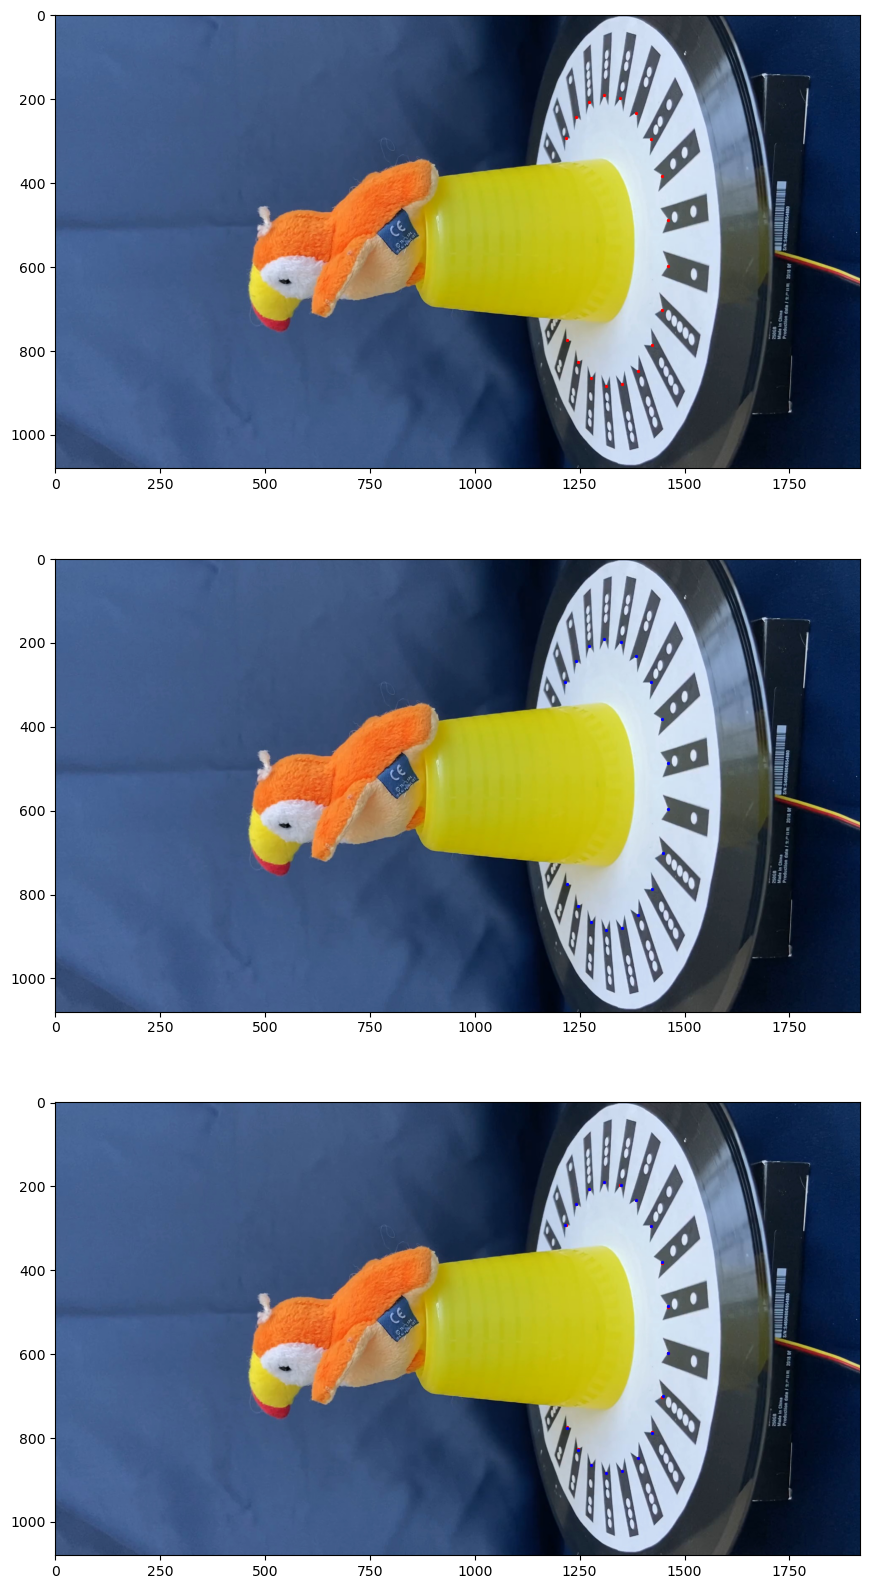

In [40]:
img = cv.imread('Data/Frame/obj1.jpg')
# 3D points OBJECT POINT world reference system
object_point_original = determine_object_point_marker()
img_RGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# find good features 
p0, concave_vertex, number = feautures_detection(img)
concave_vertex = concave_vertex.squeeze()
# take onlt the one we are interasting
# CORRESPONDIG 3D POINT (marker point) 
object_point = object_point_original[number[::]]
r_t = calcualte_rt(object_point, concave_vertex, camera_matrix, dist_coef)

point_2d = []
# for each marker point compute its corresponding 2d point
for i in object_point:

    # perform K [RT] cordinate_real_world in homogeneus 
    # padding to get the 3d homogenus cordinate of rel world
    pad = np.pad(i, (0, 1), 'constant', constant_values=(1))

    camera_point = camera_matrix.dot(r_t).dot(pad)
    # divide by w cordinate to get 2d point
    camera_3d_point = camera_point[:] / camera_point[2]
    point_2d.append(camera_3d_point[0:2])
point_2d = np.array(point_2d)




# display the project back the marker points onto the image plane 
# to check the error between the projected position and the expected marker point location.
plt.figure( figsize=(20,20)) 

# project back the marker points onto the image plane
plt.subplot(3,1,1)
for i in range(len(point_2d)):
    plt.scatter(point_2d[i][0] ,point_2d[i][1] ,s = 1.9, color="red")
plt.imshow(img_RGB)

# concave vertex find 
plt.subplot(3,1,2)
for i in range(len(point_2d)):
    plt.scatter(concave_vertex[i][0] ,concave_vertex[i][1] ,s = 1.9, color="blue")
plt.imshow(img_RGB )

# project back the marker points onto the image plane, and concave vertex
plt.subplot(3,1,3)
for i in range(len(point_2d)):
    plt.scatter(point_2d[i][0] ,point_2d[i][1] ,s = 1.9, color="red")
    plt.scatter(concave_vertex[i][0] ,concave_vertex[i][1] ,s = 1.9, color="blue")
plt.imshow(img_RGB )